# This notebook handles ingestion of stocks data to feature store

In [69]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="./")

> 2022-06-06 08:57:04,827 [info] created and saved project stocks


> <b> Steps </b>
> * [Creating mlrun function that reads stocks from yahoo_fin and returning record oriented json](#Creating-mlrun-function-that-reads-stocks-from-yahoo_fin-and-returning-record-oriented-json)
> * [Creating a feature set and declaring the graph](#Creating-a-feature-set-and-declaring-the-graph)
> * [Dummy ingestion, Deploying ingestion service and getting ingestion endpoint](#Dummy-ingestion,-Deploying-ingestion-service-and-getting-ingestion-endpoint)
> * [Testing ingestion service](#Testing-ingestion-service)
> * [Creating scheduled mlrun job to invoke our function every time delta](#Creating-scheduled-mlrun-job-to-invoke-our-function-every-time-delta)

## Creating mlrun function that reads stocks from yahoo_fin and returning record oriented json
similar to ingest_stocks, we collect the data from within the feature-set graph. <br>
event sent to graph is real-time configuration.

In [70]:
USER_NAME = os.environ['V3IO_USERNAME']
STREAM_SHARDS = 1 # NO. of input stream shard

In [71]:
# serving function configuration
SERVING_FUNCTION_RESPONSE = 'SYNC'
MIN_REPLICAS = 1 # serving function minimum replicas
MAX_REPLICAS = 1 # serving function maximum replicas
SERVING_PROCESSING_TIME = 1 # time for the serving function to sleep
WORKER_AVAILIBALITY_TIMEOUT = 100
INGRESS_TIMEOUT = 150
USE_GPU = False # whether the serving function will use GPU (if true - REMOTE_SCALE_RANGE will determine the consumption)

In [72]:
# RemoteStep configuration
REMOTE_STEP_WORKERS = 1
MAX_IN_FLIGHT = 1  # how many simulteneous events on each worker in the serving function
REMOTE_STEP_HTTP_TIMEOUT = 150
STOREY_QUEUE_SIZE = 8
WINDOW_ACK = (STOREY_QUEUE_SIZE+MAX_IN_FLIGHT)*STREAM_SHARDS

In [73]:
streams_prefix = "v3io:///users/"+USER_NAME+"/"
news_stream = streams_prefix + "news_stream"


In [74]:
import nuclio
import mlrun

model_location = 'https://iguazio-sample-data.s3.amazonaws.com/models/model.pt'
scaled_function = mlrun.import_function('hub://sentiment_analysis_serving:development')
scaled_function.spec.min_replicas = MIN_REPLICAS
scaled_function.spec.max_replicas = MAX_REPLICAS
scaled_function.add_model('sentiment_analysis_model', model_path=model_location,
                          class_name='SentimentClassifierServing')

scaled_function.with_http(workers=REMOTE_STEP_WORKERS, gateway_timeout=INGRESS_TIMEOUT,
                          worker_timeout=WORKER_AVAILIBALITY_TIMEOUT)

env_vars = {"SERVING_FUNCTION_TIME_TO_SLEEP": SERVING_PROCESSING_TIME}

scaled_function.set_envs(env_vars)
scaled_function.spec.readiness_timeout = 300
address = scaled_function.deploy()

> 2022-06-06 08:57:26,864 [info] Starting remote function deploy
2022-06-06 08:57:27  (info) Deploying function
2022-06-06 08:57:27  (info) Building
2022-06-06 08:57:27  (info) Staging files and preparing base images
2022-06-06 08:57:27  (info) Building processor image
2022-06-06 08:59:23  (info) Build complete
2022-06-06 09:01:21  (info) Function deploy complete
> 2022-06-06 09:01:22,333 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-avia-sentiment-analysis-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-avia-sentiment-analysis-serving-stocks-avia.default-tenant.app.dev39.lab.iguazeng.com/']}


In [75]:
#mlrun: start-code

import yahoo_fin.stock_info as si
import yahoo_fin.news as ynews
from dateutil import parser
import pandas as pd
import json
import requests
from storey import MapClass, Event
import string
import mlrun

def print_event(event):    
    sentiment = event.body['outputs']['predictions'][0]/2
    return_event = Event(body={'sentiment': sentiment}, key=event.body['outputs']['meta_data']['ticker'], time=event.body['outputs']['meta_data']['Datetime'])
    print(return_event)
    return return_event


def wrap_event(event):
    print(event)
    wrapped_event = {'meta_data': {'ticker': event['ticker'], 'Datetime': event['Datetime']}, 'inputs': [event['summary']]}
    print(wrapped_event)
    return wrapped_event

def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree


def get_news(event):
    '''
    event: dict with the following keys:
    n_stocks - how many stocks to collect
    '''
    tickers = si.tickers_sp500()[:event['n_stocks']]
    tickers_news = []
    for ticker in tickers:
        news = ynews.get_yf_rss(ticker=ticker)
        news_df = pd.DataFrame(news)
        df_copy = news_df[['title', 'summary', 'link', 'published']].copy()
        df_copy['ticker'] = ticker
        df_copy['Datetime'] = df_copy['published'].apply(lambda x: parser.parse(x).strftime('%Y-%m-%d %H:%M:%S'))
        df_copy['summary'] = df_copy['summary'].apply(lambda x: remove_punctuation(x))
        df_copy['title'] = df_copy['title'].apply(lambda x: remove_punctuation(x))
        tickers_news.append(df_copy)
    df = pd.concat(tickers_news).reset_index(drop=True)
    return json.loads(df.to_json(orient='records'))

#mlrun: end-code

## Creating a feature set and declaring the graph

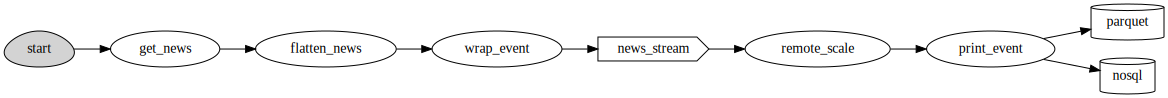

In [76]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import DateExtractor, MapValues
import yahoo_fin.stock_info as si
from mlrun.serving.remote import RemoteStep 
# creating feature set
news_set = fstore.FeatureSet("stocks_news", 
                                 entities=[fstore.Entity("ticker")],
                                 timestamp_key='Datetime', 
                                 description="stocks news feature set")

# how many tickers data we ingest (make sure same number used for ingesting news)
# n_tickers = 4

news_set.graph \
    .to(name='get_news', handler='get_news') \
    .to("storey.steps.Flatten", name="flatten_news") \
    .to(name='wrap_event', handler='wrap_event') \
    .to(">>", "news_stream", path=news_stream,shards = STREAM_SHARDS)\
    .to(RemoteStep(name="remote_scale", url=address, method="POST", max_in_flight=MAX_IN_FLIGHT,
                   timeout=REMOTE_STEP_HTTP_TIMEOUT)) \
    .to(name='print_event', handler='print_event',full_event=True)

news_set.set_targets(with_defaults=True) 
news_set.plot(rankdir="LR", with_targets=True)

## Dummy ingestion, Deploying ingestion service and getting ingestion endpoint

In [77]:
# ingesting dummy (A MUST) 
import os
import datetime

name = os.environ['V3IO_USERNAME']
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

fstore.ingest(news_set,
              pd.DataFrame.from_dict({'ticker':[name],
                                      'Datetime': now,
                                      'n_stocks':1}))

{'title': 'Heres How Much a 1000 Investment in Agilent Technologies Made 10 Years Ago Would Be Worth Today', 'summary': 'Why investing for the long run especially if you buy certain popular stocks could reap huge rewards', 'link': 'https://finance.yahoo.com/news/heres-much-1000-investment-agilent-123012973.html?.tsrc=rss', 'published': 'Fri, 03 Jun 2022 12:30:12 +0000', 'ticker': 'A', 'Datetime': '2022-06-03 12:30:12'}
{'meta_data': {'ticker': 'A', 'Datetime': '2022-06-03 12:30:12'}, 'inputs': ['Why investing for the long run especially if you buy certain popular stocks could reap huge rewards']}
{'title': 'Agilent to Participate in Goldman Sachs 43rd Annual Global Healthcare Conference', 'summary': 'SANTA CLARA Calif June 01 2022Agilent Technologies Inc NYSE A today announced the company will participate in the Goldman Sachs 43rd Annual Healthcare Conference on Wednesday June 15 in Rancho Palos Verdes California', 'link': 'https://finance.yahoo.com/news/agilent-participate-goldman-sac

""


In [78]:
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# There is an option to declare key and timestamp inside the http source (here we dont send data through the http hence not needed)
http_source = mlrun.datastore.sources.HttpSource()
news_set.spec.source = http_source

# code_to_function our mlrun wrapped function to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function(name='get_news',kind='serving',image='mlrun/mlrun', requirements=['yahoo_fin','graphviz'])
function.spec.readiness_timeout=100000

run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

In [79]:
# Deploying
news_set_endpoint = fstore.deploy_ingestion_service(featureset=news_set, run_config=run_config)

> 2022-06-06 09:02:17,862 [info] Starting remote function deploy
2022-06-06 09:02:18  (info) Deploying function
2022-06-06 09:02:18  (info) Building
2022-06-06 09:02:18  (info) Staging files and preparing base images
2022-06-06 09:02:18  (info) Building processor image
2022-06-06 09:03:03  (info) Build complete
2022-06-06 09:03:47  (info) Function deploy complete
> 2022-06-06 09:03:47,679 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-avia-get-news.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-avia-get-news-stocks-avia.default-tenant.app.dev39.lab.iguazeng.com/']}


## Testing ingestion service

In [85]:
import requests
import json

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

t = requests.post(news_set_endpoint,json={'ticker':['news'],
                                                 'Datetime': now,
                                                 'n_stocks':4})
t.text

'{"id": "9e7cd48a-8074-45bd-8091-d6e37dde874a"}'

## Creating scheduled mlrun job to invoke our function every time delta

In [ ]:
os.makedirs('src',exist_ok=True)

In [ ]:
%%writefile src/invoker.py

import requests
import datetime

def ingestion_service_invoker(endpoint): 
    now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    t = requests.post(endpoint,json={'ticker':['news'],
                                     'Datetime': now,
                                     'n_stocks':4})

In [ ]:
# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='ingestion_service_news',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':news_set_endpoint}, schedule='0 8 * * *')